In [1]:
pip install requests beautifulsoup4 pandas matplotlib

  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached beautifulsoup4-4.13.5-py3-none-any.whl.metadata (3.8 kB)
  Using cached pandas-2.3.2-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.6-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached charset_normalizer-3.4.3-cp313-cp313-win_amd64.whl.metadata (37 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
  Using cached soupsieve-2.8-py3-none-any.whl.metadata (4.6 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.2

Basic scraping template (robust & generic)

In [9]:
import requests
from bs4 import BeautifulSoup
import time
from urllib.parse import urljoin, urlparse
import pandas as pd
import re
from collections import Counter
from urllib.parse import urlparse


In [10]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/120.0.0.0 Safari/537.36"
}



In [11]:
def get_soup(url):
    resp = requests.get(url, headers=HEADERS, timeout=15)
    resp.raise_for_status()
    return BeautifulSoup(resp.text, "html.parser")


In [12]:
def find_job_links_from_search(soup, base_url):
    """Generic: find 'a' tags that look like job links (heuristic)."""
    links = set()
    for a in soup.find_all('a', href=True):
        href = a['href']
        # heuristics: contains '/internship/' or '/job/' or '/jobs/' or 'job' in path
        p = urlparse(href)
        if 'internship' in href or '/job' in href or '/jobs/' in href or 'role' in href:
            links.add(urljoin(base_url, href))
    return list(links)

In [13]:
def extract_text_try(soup, selectors):
    """Try several selectors and return first non-empty text."""
    for sel in selectors:
        el = soup.select_one(sel)
        if el and el.get_text(strip=True):
            return el.get_text(separator=' ', strip=True)
    # fallback: page title
    t = soup.title.string if soup.title else ''
    return t.strip()

In [14]:
def extract_job_fields(job_url):
    soup = get_soup(job_url)
    # Try common selectors (you will adapt these after inspecting the site)
    title = extract_text_try(soup, ["h1", ".job-title", ".heading_4_5", "h2"])
    company = extract_text_try(soup, [".company", ".company-name", ".heading_6", ".profile", ".company-name a"])
    location = extract_text_try(soup, [".location", ".job-location", ".loc"])
    salary = extract_text_try(soup, [".salary", ".stipe", ".stipend", ".salaryRange"])
    description = extract_text_try(soup, [".job-description", ".jd", "#job-desc", ".internship_details"])
    # Skills: try to find tag badges or a skills section
    skills = []
    # heuristic 1: 'skills' word and collect sibling text
    skills_section = None
    for h in soup.find_all(text=re.compile(r"Skill|Skills|Requirements|Technologies", re.I)):
        parent = h.parent
        if parent:
            skills_section = parent
            break
    if skills_section:
        text = skills_section.get_text(" ", strip=True)
        skills = re.split(r'[,\n•·\|;]+', text)
    # heuristic 2: badges / tags
    if not skills:
        badges = soup.select(".skills a, .skill, .tags span, .tags a, .chips span")
        if badges:
            skills = [b.get_text(strip=True) for b in badges]
    # final clean
    skills = [s.strip() for s in skills if s and len(s.strip())>1]
    return {
        "url": job_url,
        "title": title,
        "company": company,
        "location": location,
        "salary": salary,
        "skills": skills,
        "description": description
    }

In [15]:
def scrape_search_pages(start_url, max_jobs=100, sleep=1.5):
    base = "{uri.scheme}://{uri.netloc}".format(uri=urlparse(start_url))
    s = get_soup(start_url)
    links = find_job_links_from_search(s, base)
    jobs = []
    visited = set()
    i = 0
    for link in links:
        if i >= max_jobs:
            break
        if link in visited: continue
        try:
            data = extract_job_fields(link)
            jobs.append(data)
            i += 1
            visited.add(link)
        except Exception as e:
            print("error", link, e)
        time.sleep(sleep)
    return pd.DataFrame(jobs)

if __name__ == "__main__":
    start = "https://internshala.com/internships/data-analyst-internship"  
    df = scrape_search_pages(start, max_jobs=60, sleep=1.2)
    df.to_csv("jobs_raw.csv", index=False)
    print("Saved jobs_raw.csv, rows:", len(df))

C:\Users\kaush\AppData\Local\Temp\ipykernel_11768\769319256.py:13: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  for h in soup.find_all(text=re.compile(r"Skill|Skills|Requirements|Technologies", re.I)):


error https://internshala.com/software-testing-placement-guarantee-course?utm_source=is_web_internship-menu-dropdown 404 Client Error: Not Found for url: https://internshala.com/software-testing-placement-guarantee-course?utm_source=is_web_internship-menu-dropdown
Saved jobs_raw.csv, rows: 60


Cleaning scraped data (pandas)

In [16]:
import pandas as pd
df = pd.read_csv("jobs_raw.csv")

In [17]:
for col in ["title","company","location","salary","description"]:
    if col in df.columns:
        df[col] = df[col].fillna("").str.replace("\n"," ").str.strip()

In [18]:
df['location_clean'] = df['location'].str.split(',').str[0].str.strip().str.title()

In [19]:
import ast
def parse_skills(x):
    if pd.isna(x) or x=="":
        return []
    if isinstance(x, list):
        return x
    try:
        arr = ast.literal_eval(x)
    except Exception:
        # if plain text, split on commas/pipes
        arr = re.split(r'[,\|;•·]+', x)
    return [s.strip().title() for s in arr if s.strip()]

In [20]:
df['skills_list'] = df['skills'].apply(parse_skills)

Analysis

In [21]:
total_jobs = len(df)
top_locations = df['location_clean'].value_counts().head(10)
# skills: explode and count
skills_series = df['skills_list'].explode().dropna()
top_skills = skills_series.value_counts().head(20)

In [22]:
print("Total jobs:", total_jobs)
print("Top locations:\n", top_locations.head(5))
print("Top skills:\n", top_skills.head(10))

Total jobs: 60
Top locations:
 location_clean
Location                                                            41
Search Jobs By Location On Internshala                               1
Jio Home Service Internship In Seoni At Jio                          1
Business Analytics Internship In Bangalore At Mckinsey & Company     1
Coordinator Internship In Mumbai At Nixace Technologies              1
Name: count, dtype: int64
Top skills:
 skills_list
Jobs By Skill                                              58
Coordinator Internship In Mumbai At Nixace Technologies     1
Business Communication Skills                               1
Name: count, dtype: int64


Plot Top 5 locations (matplotlib)

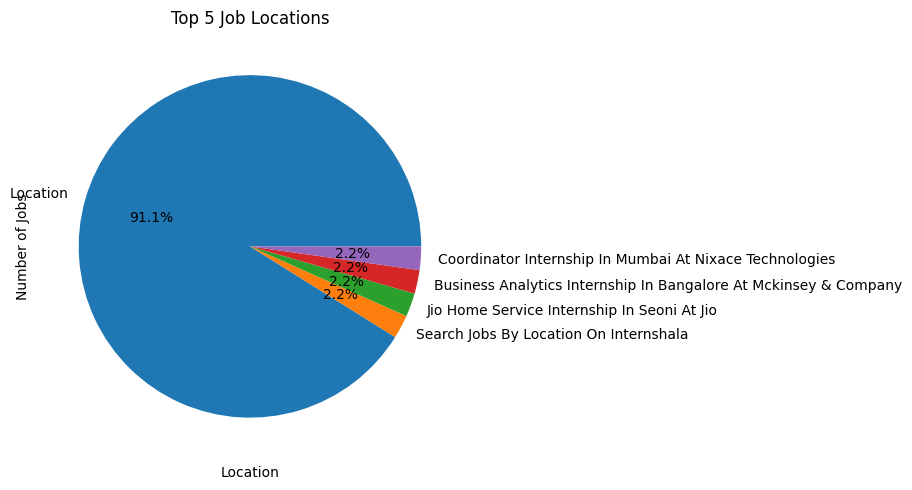

In [25]:
import matplotlib.pyplot as plt

top5 = top_locations.head(5)
plt.figure(figsize=(8,5))
top5.plot(kind='pie', autopct='%1.1f%%')
plt.title("Top 5 Job Locations")
plt.xlabel("Location")
plt.ylabel("Number of Jobs")
plt.tight_layout()
plt.savefig("top5_locations.png")
plt.show()
